In [1]:
import math
import random
import os

import numpy as np

from comet_ml import API
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

COMET_API_KEY="bSyRm6vJpAwfehizXic7Fo0bY"
COMET_REST_API_KEY="S3g50KZWG8zEgk1PLzKUn0eEq"


error_metric = 'standard_error' # can also be std

In [2]:
def read_conf_matrix(cm, pos_class=3):                                                                
    """ Calculates confusion matrix and returns true and false positives and negatives based on the 
    label specified as positive.                                                                    
                                                                                                    
    This function assumes that the classes have IDs 0, 1, 2,...                                     
                                                                                                    
    Args:                                                                                           
        y_true: True labels. 1d array or list                                                       
        y_pred: Predicted labels. 1d array or list                                                  
        classes: List of IDs of class labels. dim=n_classes                                         
        pos_class: ID of label to take as positive class                                            
                                                                                                    
    Returns:                                                                                        
        cm: confusion matrix of n_labels x n_labels                                                 
        tp: true positives                                                                          
        tn: true negatives                                                                          
        fp: false positives                                                                         
        fn: false negatives                                                                         
    """                                                                                             
    cm = np.array(cm)
    n_classes = 4
    tp = tn = fp = fn = p = n = 0

    for row in range(n_classes):                                                                    
        for col in range(n_classes):                                                                
            if row == col:                                                                          
                if row == pos_class:                                                                
                    tp = cm[row,col]                                                                
                else:                                                                               
                    tn += cm[row,col]                                                               
            else:                                                                                   
                if col == pos_class:                                                                
                    fp += cm[row,col]                                                               
                else:                                                                               
                    fn += cm[row,col]                                                               
            if row == pos_class:        # TODO: it might be possible to optimise this and not have another if statement.
                p += cm[row, col]                                                                   
                                                                                                    
    return tp, tn, fp, fn, p, n     # TODO: function doesn't yet calculate 'n'                      



def parse_conf_mat(exp_id):
    exp = client.get_experiment_stdout(exp_id)

    confusion_mat = exp.split('Evaluate')[1]
    confusion_mat = confusion_mat.split('Confusion matrix: \n ')[1]

    confusion_mat = confusion_mat.split('Testing accuracy')[0]
    matrix = []
    for part in confusion_mat.split('\n')[2:]:
        a = part.split('[ ')[1].replace(']','')
        a = np.array(a.split(' '))
        x = np.nonzero(a)
        matrix.append([float(str(y)) for y in a[x]])
    
    
    mat = np.zeros((4,4))
    mat[2] = matrix[0]
    mat[3] = matrix[1]
    # make sure the numbers add up:
    assert int(np.sum(matrix)) == 312
    return mat

def specificity(tp, tn, fp, fn, p, n):
    if tn + fp == 0:
        return 0.
    return tn / (tn + fp)

def recall(tp, tn, fp, fn, p, n):
    if int(p) == 0:
        return 0.
    return sensitivity(tp, fp, fn, tn, p, n)
    
def sensitivity(tp,tn,fp,fn, p, n):
    if p == 0:
        return 0.
    return tp / p

def precision(tp,tn,fp,fn, p, n):
    if int(tn + fp) == 0:
        return 0.
    val =  tp / (tp + fp)
    if np.isnan(val):
        return 0.
    return val


def f1(*args):
    pr = precision(*args)
    rc = sensitivity(*args)
    if int(pr + rc) == 0:
        return 0.
    val =  (2 * pr * rc ) / ( pr + rc)
    return val

def calc_sens_spec_uar(conf_mat, pos_class=3):                               
    tp, tn, fp, fn, p, n = read_conf_matrix(conf_mat, pos_class=pos_class) 
    sens = tp / (tp + fn)                                                            
    spec = tn / (tn + fp)                                                            
    uar = (sens + spec) / 2                                                          
    return sens, spec, uar                                                           


In [3]:
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto-interspeech")

def experiments_to_results(experiments):
    results = {
        'no-transfer': [],
        'vctk-transfer': [],
        'sc-transfer': [],
        #'svm': [],   
    }

    result_matrices = {
        'no-transfer': [],
        'vctk-transfer': [],
        'sc-transfer': [],
        #'svm': [],   
    }


    for exp in experiments:
        tags = client.get_experiment_tags(exp)

        if len(tags) > 0 and tags[0] in results.keys():
            tag = tags[0]
            metrics = client.get_experiment_metrics(exp)
            params = client.get_experiment_parameters(exp)
            for metric in metrics:
                if metric['name'] == 'test_UAR':
                    results[tag].append(metric['valueMax'])
            mat = parse_conf_mat(exp)
            result_matrices[tag].append(mat)
    return results, result_matrices

def plot_results(results):
    errors = []
    xs = []
    ys = []
    for idx, (k, values) in enumerate(results.items()):
        xs.append(k)
        values = [float(v) for v in values]
        ys.append(np.mean(values))
        if error_metric == 'standard_error':
            errors.append(stats.sem(values))
        else:
            errors.append(np.std(values))

    fig, ax = plt.subplots(figsize=(10,5))

    el = ax.errorbar(xs, ys, yerr=errors, fmt='-', color='darkblue', ecolor='darkblue', elinewidth=1.3, capsize=6)
    elines = el.get_children()
    #elines[3].set_color('green')
    ax.set_xticklabels(results.keys(), rotation=45, fontsize=14)
    ax.set_ylabel('UAR', fontsize=13)
    ax.set_xlabel('Source Dataset', fontsize=13)
    plt.grid()
    plt.show()




In [137]:
results, result_matrices = experiments_to_results(experiments)

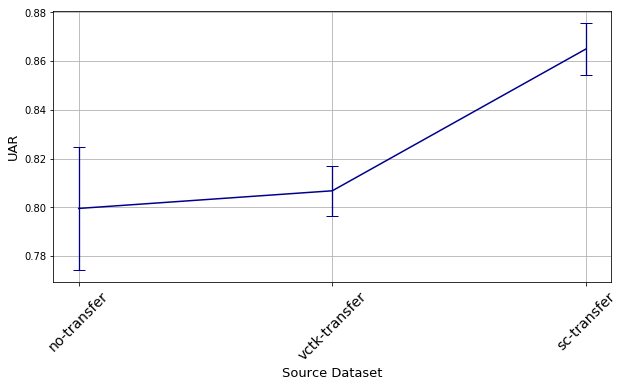

In [139]:
plot_results(results)

In [152]:
rows = []
for key in result_matrices.keys():
    for mat in result_matrices[key]:
        ss, sp, uar = calc_sens_spec_uar(mat)
        mat = read_conf_matrix(mat)
        f = f1(*mat)

        rows.append((key, uar, ss, sp, pr, f))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in double_scalars


In [153]:

import pandas as pd


def pct(val):
    if type(val) == str:
        return val
    v = round(val * 100, 2)
    return v

def mean(val):
    x = np.mean(val)
    return f'{round(x,1)}'

def std(val):
    x = np.std(val)
    return round(x,1)

def serr(val):
    x = stats.sem(val)
    return round(x,1)


df = pd.DataFrame(rows, columns=["Model", "UAR (%)", "Sensitivity (%)", "Specificity (%)", "Precision (%)", "F1"])
df = df.applymap(pct)
if error_metric == 'standard_error':
    table = df.groupby("Model")["UAR (%)", "Sensitivity (%)","Specificity (%)", "Precision (%)", "F1"].agg([mean, serr])
else:
    table = df.groupby("Model")["Sensitivity (%)","Specificity (%)", "Precision (%)", "F1"].agg([mean, std])
display(table)
print(table.to_latex())

UAR (%)      Sensitivity (%)      Specificity (%)       \
                 mean serr            mean serr            mean serr   
Model                                                                  
no-transfer      80.0  2.5            71.8  5.8            88.1  0.8   
sc-transfer      86.5  1.1            84.1  2.2            88.9  0.4   
vctk-transfer    80.7  1.0            72.2  2.1            89.1  0.3   

              Precision (%)         F1       
                       mean serr  mean serr  
Model                                        
no-transfer            65.7  0.0  59.2  4.7  
sc-transfer            65.7  0.0  70.6  1.2  
vctk-transfer          65.7  0.0  67.7  1.2

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{UAR (\%)} & \multicolumn{2}{l}{Sensitivity (\%)} & \multicolumn{2}{l}{Specificity (\%)} & \multicolumn{2}{l}{Precision (\%)} & \multicolumn{2}{l}{F1} \\
{} &    mean & serr &            mean & serr &            mean & serr &          mean & serr &  mean & serr \\
Model         &         &      &                 &      &                 &      &               &      &       &      \\
\midrule
no-transfer   &    80.0 &  2.5 &            71.8 &  5.8 &            88.1 &  0.8 &          65.7 &  0.0 &  59.2 &  4.7 \\
sc-transfer   &    86.5 &  1.1 &            84.1 &  2.2 &            88.9 &  0.4 &          65.7 &  0.0 &  70.6 &  1.2 \\
vctk-transfer &    80.7 &  1.0 &            72.2 &  2.1 &            89.1 &  0.3 &          65.7 &  0.0 &  67.7 &  1.2 \\
\bottomrule
\end{tabular}



### Scores for SVM model
Compute mean and standard error of relevant metrics for SVM experiments

In [9]:
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto")

svm_f1 = []
svm_sens = []
svm_spec = []
svm_prec = []

# get confusion matrix params (tp, tn, fp, & fn) and compute desired metrics from svm experiments
for exp in experiments:
    tags = client.get_experiment_tags(exp)
    
    if len(tags) > 0 and tags[0] == 'svm':
        print('Retrieving experiment {}...'.format(exp))
        tag = tags[0]
        metrics = client.get_experiment_metrics(exp)
        tp = tn = fp = fn = 0
        for metric in metrics:
            if metric['name'] == 'true_positives':
                tp = float(metric['valueMax'])
            elif metric['name'] == 'true_negatives':
                tn = float(metric['valueMax'])
            elif metric['name'] == 'false_positives':
                fp = float(metric['valueMax'])
            elif metric['name'] == 'false_negatives':
                fn = float(metric['valueMax'])
        p = tp + fn
        n = fp + tn
        svm_sens.append(sensitivity(tp, tn, fp, fn, p, n) * 100)
        svm_spec.append(specificity(tp, tn, fp, fn, p, n) * 100)
        svm_prec.append(precision(tp, tn, fp, fn, p, n) * 100)
        svm_f1.append(f1(tp, tn, fp, fn, p, n) * 100)

# print('f1', svm_f1)
# print('prec', svm_prec)
print('F1 = {0}({1})'.format(np.round(np.mean(svm_f1),1), np.round(stats.sem(svm_f1),1)))
print('Sens = {0}({1})'.format(np.round(np.mean(svm_sens),1), np.round(stats.sem(svm_sens),1)))
print('Spec = {0}({1})'.format(np.round(np.mean(svm_spec),1), np.round(stats.sem(svm_spec),1)))
print('Prec = {0}({1})'.format(np.round(np.mean(svm_prec),1), np.round(stats.sem(svm_prec),1)))

Retrieving experiment 95c04edc06c545f986869bac8c8d842d...
Retrieving experiment 7f6517f2fe754aaea9df64245f39f5d7...
Retrieving experiment 2f92fbc59b824e2cbd576d4cdfd8723b...
Retrieving experiment 0c7d9e546da24e1bbf7adf1ac41c19c9...
Retrieving experiment 6009b10cb7cf4b14b687a7fb57dc53bf...
F1 = 66.2(1.0)
Sens = 81.1(1.8)
Spec = 86.9(0.1)
Prec = 56.0(0.6)


# Noise Plots

In [62]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto-noise")

noise_types = ['gaussian', 'children_playing', 'siren', 'dog_bark']
model_types = ['no-transfer', 'sc-transfer', 'vctk-transfer', 'svm']

results = {}
for noise in noise_types:
    results[noise] = {}
    for model in model_types:
        results[noise][model] = []

for exp in experiments:
    noise_type = None
    for param in client.get_experiment_parameters(exp):
        if param['name'] == 'noise_type':
            noise_type = param['valueCurrent']

    if noise_type is None:
        continue

    tags = client.get_experiment_tags(exp)
    if len(tags) > 0 and tags[0] in model_types:
        tag = tags[0]
        experiment = []
        metrics = client.get_experiment_metrics_raw(exp)
        for metric in metrics:
            if metric['metricName'] == 'test_UAR':
                result = float(metric['metricValue'])
                if (np.isnan(result)):
                    result = 0.5
                experiment.append(result)
        results[noise_type][tag].append(experiment)

<Figure size 432x288 with 0 Axes>

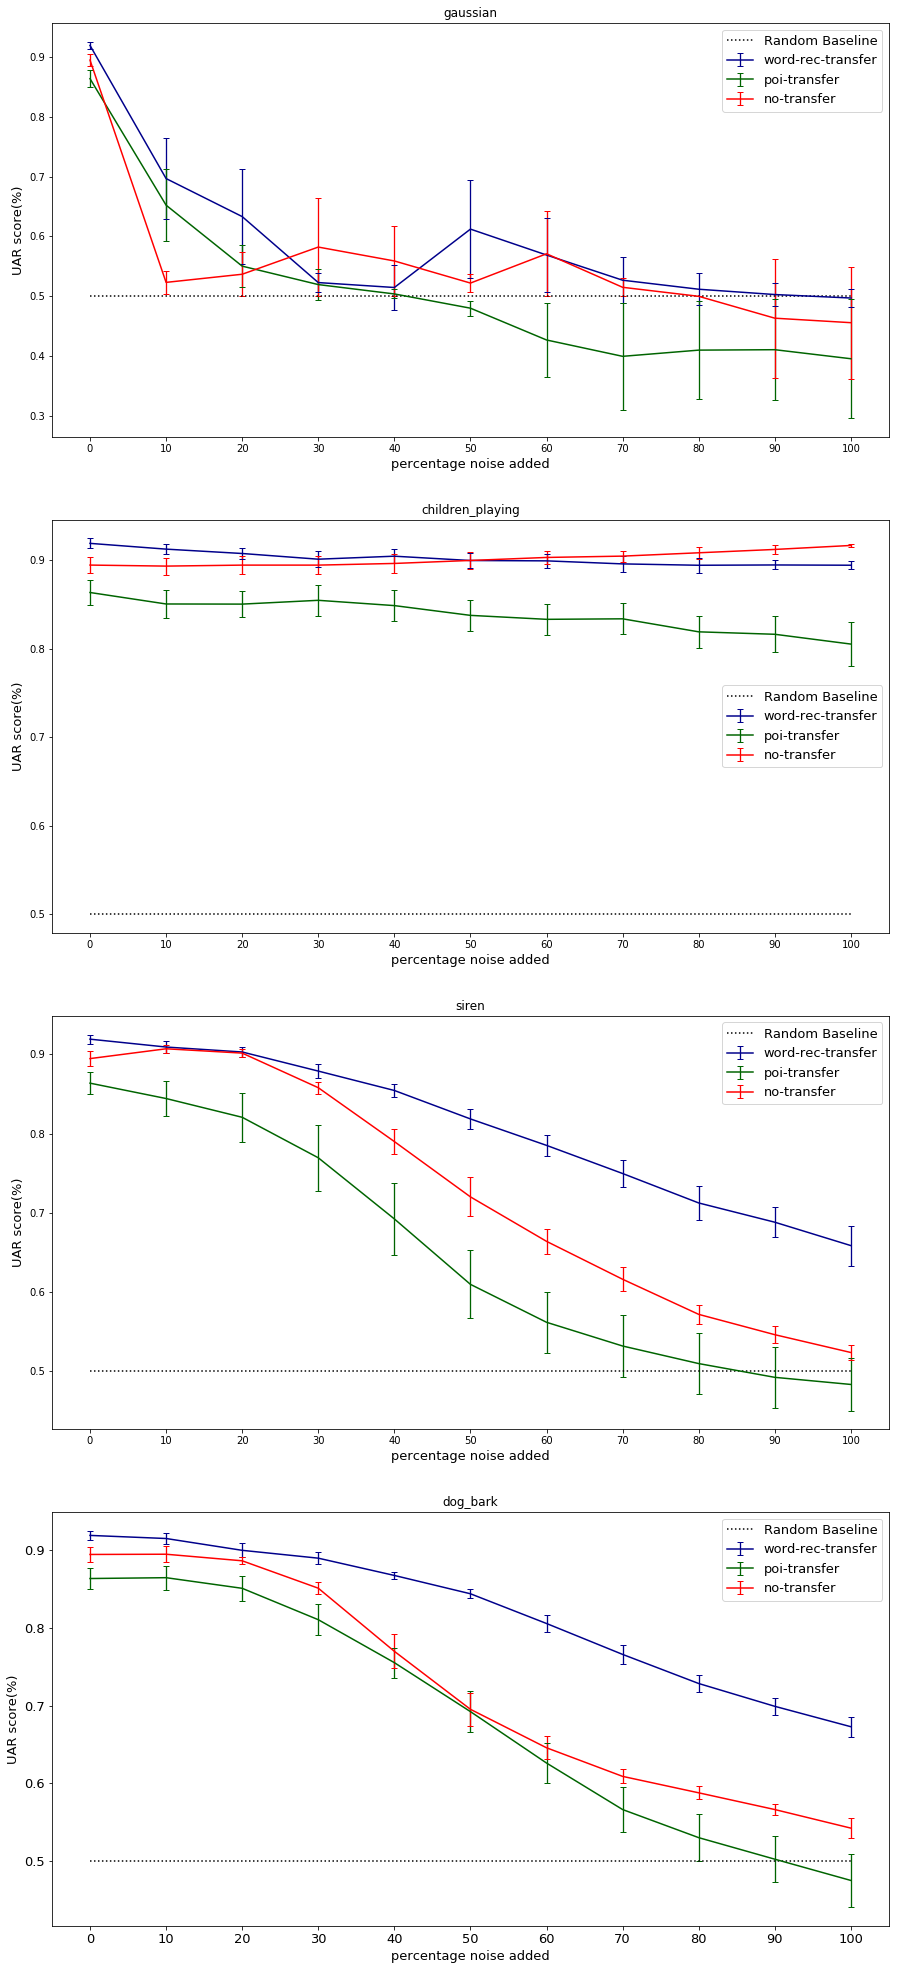

In [63]:
#%matplotlib qt
#%matplotlib inline

results_w_errors = {}
for noise in noise_types: 
    results_w_errors[noise] = {}

for noise_type in results.keys():
    for source_model in results[noise_type].keys():
        mu = np.mean(results[noise_type][source_model], axis=0)
        if error_metric == 'standard_error':
            serr = stats.sem(results[noise_type][source_model], axis=0)
        else:
            std = np.std(results[noise_type][source_model], axis=0)
        
        results_w_errors[noise_type][source_model] = (mu, serr)

lines = [
    ('sc-transfer', 'darkblue', 'word-rec-transfer'),
    ('vctk-transfer', 'darkgreen', 'poi-transfer'),
    ('no-transfer', 'red', 'no-transfer'),
#    ('svm', 'green', 'SVM')
]

plt.figure()
fig, axs = plt.subplots(4,1, sharex=False, figsize=(15,35))
plt.setp(axs, xticks=np.arange(11),  xticklabels=[f'{(v) * 10}' for v in range(11)])
plt.tick_params(labelsize=13)
for idx, key in enumerate(results.keys()):
    for (line, color, label) in lines:  
        xs = np.arange(11)
        ys = results_w_errors[key][line][0]
        errors = results_w_errors[key][line][1]
        axs[idx].errorbar(xs, ys, yerr=errors, fmt='-', color=color, label=label, ecolor=color, 
                          elinewidth=1.3, capsize=3)
        
        ln = (np.zeros(11) + 0.5) # random baseline
    

    axs[idx].set_title(key)
    axs[idx].plot(np.arange(11), ln , linestyle=':', color='black', label='Random Baseline')
    axs[idx].set_ylabel('UAR score(%)', fontsize=13)
    axs[idx].set_xlabel('percentage noise added', fontsize=13)
    axs[idx].legend(fontsize=13)
plt.show()

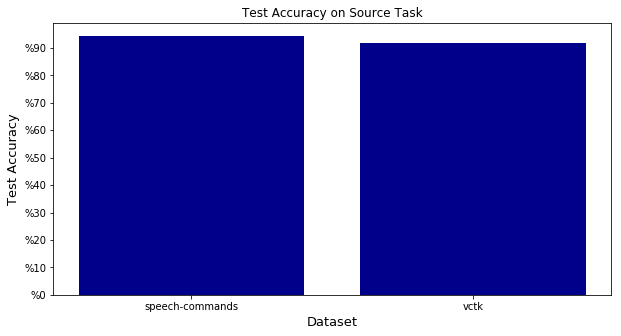

In [49]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)

projects = ('speech-commands-train-and-evaluate',
            'vctk-train-and-evaluate')


results = {}

for project in projects:
    best_val = 0.
    experiments = client.get(f"co-jl-transfer/{project}")
    for exp in experiments:
        tags = client.get_experiment_tags(exp)
        if 'candidate' in tags:
            metrics = client.get_experiment_metrics(exp)
            for metric in metrics:
                if metric['name'] == 'test_accuracy':
                    best_val = metric['valueMax']

    results[project.replace('-train-and-evaluate','')] = float(best_val)

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(list(results.keys()), list(results.values()), color='darkblue')
plt.yticks(np.arange(10) / 10, [f'%{(v) * 10}' for v in range(10)])

ax.set_title("Test Accuracy on Source Task")
ax.set_xlabel("Dataset", fontsize=13)
ax.set_ylabel("Test Accuracy", fontsize=13)
plt.show()

In [64]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)

model_types = ['no-transfer', 'sc-transfer', 'vctk-transfer', 'svm']

results = {}
for model in model_types:
    results[model] = []

experiments = client.get(f"co-jl-transfer/chillanto-frequency-mask")
for exp in experiments:
    tags = client.get_experiment_tags(exp)
    metrics = client.get_experiment_metrics_raw(exp)
    experiment = []
    for metric in metrics:
        if metric['metricName'] == 'test_UAR':
            experiment.append(float(metric['metricValue']))
    results[tags[0]] = experiment


# Ablation

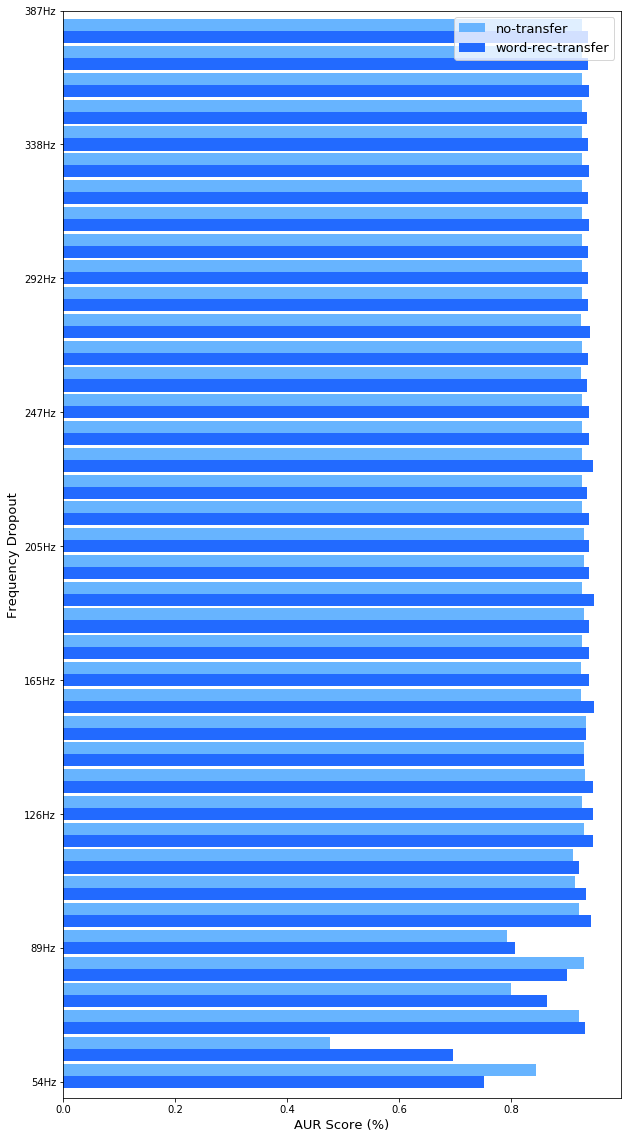

In [158]:
import numpy as np

def freq_to_mel(freq_val):
    mel_val = 1125 * np.log(1 + freq_val/700)
    return mel_val
    
def mel_to_freq(mel_val):
    freq_val = 700 * (np.exp(mel_val/1125) - 1)
    return freq_val

fmin = 20
fmax = 4000
n_mels = 40

# Convert min and max frequency to mel scale
fmin_in_mel = freq_to_mel(fmin)
fmax_in_mel = freq_to_mel(fmax)
# print('fmin in mel ', fmin_in_mel)
# print('fmax in mel', fmax_in_mel)

# Get n_mels linearly-spaced mel frequencies between min and max
# add 2 to no of points because we use triangular filters (which span 2 banks).
filterbanks_pts_mel = np.linspace(fmin_in_mel, fmax_in_mel, n_mels + 2)
filterbank_pts_freq = mel_to_freq(filterbanks_pts_mel)
# print('filterbank points in mel: ', filterbanks_pts_mel)
# print('filterbank points in freq: ', filterbank_pts_freq)

# print range of each filter bank.
yticks = []
for i in range(len(filterbank_pts_freq) - 2):
    start_freq = filterbank_pts_freq[i]
    end_freq = filterbank_pts_freq[i+2]
    #print('Mel {}: {} - {}Hz'.format(i+1, np.round(start_freq), np.round(end_freq)))
    yticks.append(f'{int(np.round(start_freq))}Hz')
    
    

fig, ax = plt.subplots(figsize=(10,20))
ax.set_yticklabels(yticks)

ind = np.arange(40)
width = 0.45

ax.barh(ind + width, results['no-transfer'], width, color='#67B4FF', label='no-transfer')
ax.barh(ind , results['sc-transfer'], width, color='#226AFF', label='word-rec-transfer')
ax.set(ylim=[2*width - 1.5, 40])
ax.set_xlabel("AUR Score (%)",fontsize=13)
ax.set_ylabel("Frequency Dropout", fontsize=13)
ax.legend(loc=1, fontsize=13)
plt.show()


# Timeshift


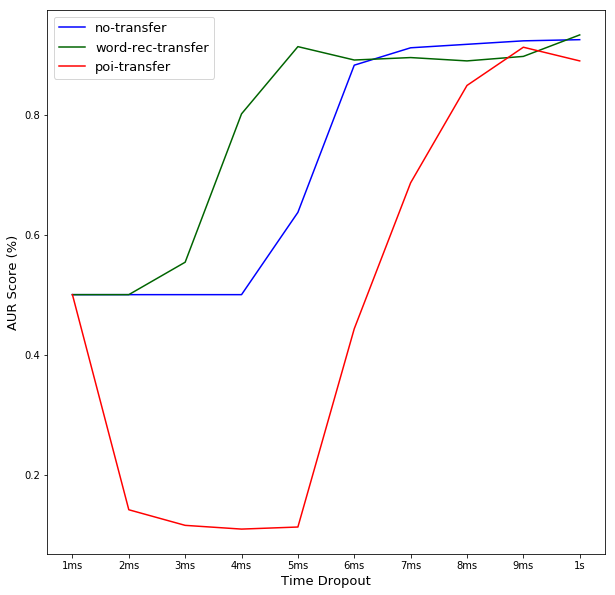

In [196]:
# NOTE: Charles I think F1 communicates this plot better...

client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)

model_types = ['no-transfer', 'sc-transfer', 'vctk-transfer', 'svm']

results = {}
for model in model_types:
    results[model] = []

experiments = client.get(f"co-jl-transfer/chillanto-timeshift-crop")
for exp in experiments:
    tags = client.get_experiment_tags(exp)
    metrics = client.get_experiment_metrics_raw(exp)
    experiment = []
    for metric in metrics:
        if metric['metricName'] == 'test_UAR':
            experiment.append(float(metric['metricValue']))
    results[tags[0]] = experiment


    

fig, ax = plt.subplots(figsize=(10,10))
ind = np.arange(40)
width = 0.45
xticks = [f'{f + 1}ms' for f in np.arange(10)]
xticks[-1] = '1s'

ax.plot(np.arange(10), results['no-transfer'], color='blue', label='no-transfer')
ax.plot(np.arange(10), results['sc-transfer'], color='darkgreen', label='word-rec-transfer')
ax.plot(np.arange(10), results['vctk-transfer'], color='red', label='poi-transfer')
ax.legend(fontsize=13)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xticks)
ax.set_ylabel("AUR Score (%)",fontsize=13)
ax.set_xlabel("Time Dropout", fontsize=13)
plt.show()